# PROJECT-3. EDA + Feature Engineering

## 1. Импортируем библиотеки и загрузим данные.

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Для анализа отзывов
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Для кодирования категориальных признаков
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [11]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [12]:
# подгрузим наши данные из соревнования

INPUT_DIR = 'https://github.com/RuslanMavlitov/sf_data_science/raw/main/Project_3_EDA/'
df_train = pd.read_csv(INPUT_DIR+'/hotels_train.csv.zip') # датасет для обучения
df_test = pd.read_csv(INPUT_DIR+'hotels_test.csv.zip') # датасет для предсказания
sample_submission = pd.read_csv(INPUT_DIR+'/submission.csv.zip') # самбмишн

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [14]:
df_train.head(3)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   

                          hotel_name reviewer_nationality  \
0                 The May Fair Hotel      United Kingdom    
1    Mercure London Bloomsbury Hotel      United Kingdom    
2  Legend Saint Germain by Elegancia               China    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   

   total_number_of_reviews      positive_review  \
0                     1994   Staff were amazing   
1                     1361             location   
2                      406          No Positive   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097  
2  48.845377  2.325643

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [16]:
df_test.head(3)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   
2        Mallorca 251 Eixample 08008 Barcelona Spain   

   additional_number_of_scoring review_date  average_score  \
0                           904   7/21/2017            8.1   
1                           612  12/12/2016            8.6   
2                            46  11/26/2015            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci      United Kingdom    
1                           Urban Lodge Hotel             Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton              Sweden    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   

         lat       lng  
0  45.533137  9.171102  
1  52.385649  4.834443  
2  41.393192  2.161520

In [17]:
sample_submission.head()

reviewer_score      id
0               1  488440
1              10  274649
2               3  374688
3              10  404352
4               9  451596

In [18]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [19]:
# для корректной обработки признаков объединяем train и test в один датасет
df_train['sample'] = 1 # помечаем тренировочную выборку
df_test['sample'] = 0 # помечаем тестовую выборку
df_test['reviewer_score'] = 0 # в test у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat(
    [df_train, df_test], 
    ignore_index=True
)
data.head(3)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   

                          hotel_name reviewer_nationality  \
0                 The May Fair Hotel      United Kingdom    
1    Mercure London Bloomsbury Hotel      United Kingdom    
2  Legend Saint Germain by Elegancia               China    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   

   total_number_of_reviews      positive_review  \
0                     1994   Staff were amazing   
1                     1361             location   
2                      406          No Positive   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   

         lat       lng  sample  
0  51.507894 -0.143671       1  
1  51.521009 -0.123097       1  
2  48.845377  2.325643       1

### Признаки
+ hotel_address - адрес отеля
+ review_date - дата, когда рецензент разместил соответствующий отзыв.
+ average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
+ hotel_name - название отеля
+ reviewer_nationality - национальность рецензента
+ negative_review - отрицательный отзыв, который рецензент дал отелю.
+ review_total_negative_word_counts - общее количество слов в отрицательном отзыв
+ positive_review - положительный отзыв, который рецензент дал отелю
+ review_total_positive_word_counts - общее количество слов в положительном отзыве
+ reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
+ total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
+ total_number_of_reviews - общее количество действительных отзывов об отеле
+ tags - теги, которые рецензент дал отелю.
+ days_since_review - продолжительность между датой проверки и датой очистки
+ additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
+ lat - широта отеля
+ lng - долгота отеля

In [20]:
data.head(3)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   

                          hotel_name reviewer_nationality  \
0                 The May Fair Hotel      United Kingdom    
1    Mercure London Bloomsbury Hotel      United Kingdom    
2  Legend Saint Germain by Elegancia               China    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   

   total_number_of_reviews      positive_review  \
0                     1994   Staff were amazing   
1                     1361             location   
2                      406          No Positive   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   

         lat       lng  sample  
0  51.507894 -0.143671       1  
1  51.521009 -0.123097       1  
2  48.845377  2.325643       1

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# 2. EDA
### Преварительный анализ данных

In [22]:
# для предварительного анализа используем Pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Info about booking hotels")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Из предоставленных данных можно сделать несколько выводов:
+ в колонках 'lat' и 'lng' есть 6536 пропусков
+ в датасете присутствуют 336 дубликатов
+ между признаками 'additional_number_of_scoring' и 'total_number_of_reviews' наблюдается сильная корреляция

In [23]:
# избавимся от признака additional_number_of_scoring
data = data.drop('additional_number_of_scoring', axis=1)

### Работа с признаками
Признак hotel_address

In [24]:
# создадим новый признак hotel_city
# город в котором находится отель
data['hotel_city'] = data['hotel_address'].apply(lambda x: 'London' if x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-2])

In [25]:
# проверим количество городов
data['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [26]:
# городов всего 6, закодируем их методом OneHotEncoding
encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True)
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

data.head(2)

hotel_address review_date  \
0  Stratton Street Mayfair Westminster Borough Lo...   2/19/2016   
1  130 134 Southampton Row Camden London WC1B 5AF...   1/12/2017   

   average_score                       hotel_name reviewer_nationality  \
0            8.4               The May Fair Hotel      United Kingdom    
1            8.3  Mercure London Bloomsbury Hotel      United Kingdom    

   negative_review  review_total_negative_word_counts  \
0         Leaving                                   3   
1   poor breakfast                                  3   

   total_number_of_reviews      positive_review  \
0                     1994   Staff were amazing   
1                     1361             location   

   review_total_positive_word_counts  ...        lat       lng sample  \
0                                  4  ...  51.507894 -0.143671      1   
1                                  2  ...  51.521009 -0.123097      1   

  hotel_city  hotel_city_London  hotel_city_Paris  hotel_city_Amsterdam  \
0     London                  1                 0                     0   
1     London                  1                 0                     0   

  hotel_city_Milan  hotel_city_Vienna  hotel_city_Barcelona  
0                0                  0                     0  
1                0                  0                     0  

[2 rows x 24 columns]

In [27]:
# удалим столбцы с адресом и городом отеля
data = data.drop(['hotel_address','hotel_city'], axis=1)

Признак reviewer_nationality

In [28]:
# проверим распределение национальностей ревьюеров
data.reviewer_nationality.value_counts(normalize=True)[:15]

 United Kingdom               0.475524
 United States of America     0.068711
 Australia                    0.042048
 Ireland                      0.028749
 United Arab Emirates         0.019845
 Saudi Arabia                 0.017356
 Netherlands                  0.017009
 Switzerland                  0.016826
 Germany                      0.015397
 Canada                       0.015306
 France                       0.014147
 Israel                       0.012817
 Italy                        0.011855
 Belgium                      0.011694
 Turkey                       0.010556
Name: reviewer_nationality, dtype: float64

Так как, порядка 70% ревьюверов, приходится на первые 10 стран, то учтем их, а остальные пометим как 'other'. Закодируем с помощью бинарного кодирования.

In [29]:
popular_nationality = data['reviewer_nationality'].value_counts().nlargest(10)
data['nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in popular_nationality else 'Other')
data.head()

review_date  average_score                                 hotel_name  \
0   2/19/2016            8.4                         The May Fair Hotel   
1   1/12/2017            8.3            Mercure London Bloomsbury Hotel   
2  10/18/2016            8.9          Legend Saint Germain by Elegancia   
3   9/22/2015            7.5  Mercure Paris 19 Philharmonie La Villette   
4    3/5/2016            8.5                Golden Tulip Amsterdam West   

  reviewer_nationality      negative_review  \
0      United Kingdom              Leaving    
1      United Kingdom        poor breakfast   
2               China    No kettle in room    
3      United Kingdom           No Negative   
4              Poland          Torn sheets    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   
2                                  6                      406   
3                                  0                      607   
4                                  4                     7586   

                                     positive_review  \
0                                 Staff were amazing   
1                                           location   
2                                        No Positive   
3   Friendly staff quiet comfortable room spotles...   
4   The staff was very friendly and helpful Break...   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  ...        lat       lng  \
0                                           7  ...  51.507894 -0.143671   
1                                          14  ...  51.521009 -0.123097   
2                                          14  ...  48.845377  2.325643   
3                                           8  ...  48.888697  2.394540   
4                                          10  ...  52.385601  4.847060   

  sample  hotel_city_London  hotel_city_Paris  hotel_city_Amsterdam  \
0      1                  1                 0                     0   
1      1                  1                 0                     0   
2      1                  0                 1                     0   
3      1                  0                 1                     0   
4      1                  0                 0                     1   

   hotel_city_Milan  hotel_city_Vienna  hotel_city_Barcelona       nationality  
0                 0                  0                     0   United Kingdom   
1                 0                  0                     0   United Kingdom   
2                 0                  0                     0             Other  
3                 0                  0                     0   United Kingdom   
4                 0                  0                     0             Other  

[5 rows x 23 columns]

In [30]:
bin_encoder = ce.BinaryEncoder(cols=['nationality'])
type_bin = bin_encoder.fit_transform(data['nationality'])

data = pd.concat([data, type_bin], axis=1)

In [31]:
# удалим признаки reviewer_nationality и nationality
data = data.drop(['reviewer_nationality', 'nationality'], axis=1)

Признак tags

In [32]:
# проведем преобразования признака
data.tags = data.tags.apply(lambda x: str(x).replace('[', ''))
data.tags = data.tags.apply(lambda x: str(x).replace(']', ''))
data.tags = data.tags.apply(lambda x: str(x).replace("' ", ""))
data.tags = data.tags.apply(lambda x: str(x).replace(" '", ""))
data.tags = data.tags.apply(lambda x: str(x).replace(', ', ','))
data.tags = data.tags.apply(lambda x: str(x).split(','))

In [33]:
# выделим топ-10 тэгов
data.tags.explode().value_counts()[:10]

Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Name: tags, dtype: int64

In [34]:
# создадим новые признаки тэгов
top_10_tags = list(data['tags'].explode().value_counts().index)[:10]

for i in top_10_tags:
    data[i] = data['tags'].apply(lambda x: 1 if i in x else 0)

In [35]:
# удалим признак tags
data = data.drop('tags',axis=1)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_date                                 515738 non-null  object 
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   positive_review                             515738 non-null  object 
 7   review_total_positive_word_counts           515738 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

Признаки negative_review и positive_review

In [37]:
# проведем оценку с помощью библиотеки nltk и выделим общую оценку
sent_analyzer = SentimentIntensityAnalyzer()

data['negative_review_num'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
data['positive_review_num'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

# удалим исходные признаки
data = data.drop(['negative_review','positive_review'], axis=1)

Признак days_since_review

In [38]:
# создадим новый числовой признак
data['days_since_review_int'] = data.days_since_review.apply(lambda x: x.split(' ')[0])
data['days_since_review_int'] = data.days_since_review_int.astype(int)
# удалим исходный признак
data = data.drop('days_since_review', axis=1)

Признак hotel_name

In [39]:
# т.к. признак содержит больше 1000 значений, то закодируем его методом LabelEncoder
data['hotel_name_num'] = LabelEncoder().fit_transform(data['hotel_name'])

# удалим исходный признак
data = data.drop('hotel_name', axis=1)

Признаки lat и lng

In [40]:
# заполним пропуски модой
data['lat'].fillna(data['lat'].mode()[0], inplace=True)
data['lng'].fillna(data['lng'].mode()[0], inplace=True)

Признак review_date

In [41]:
# приведем признак к формату datetime и создадим новый признак месяца отзыва
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=True)
data['review_month'] = data['review_date'].dt.month

# удалим исходный признак
data = data.drop('review_date', axis=1)

c:\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '10/18/2016' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '12/30/2015' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '11/24/2015' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '10/19/2016' in MM/DD/YYYY format. Provide format or specify infer_datetime_for

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   reviewer_score                              515738 non-null  float64
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   hotel_city_London                           515738 non-null  int64  
 

Стандартизация

In [43]:
# проведем стандартизацию числовых признаков
col_names = data[['average_score','review_total_negative_word_counts','total_number_of_reviews',
                  'review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given',
                  'hotel_name_num']]

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

data_s = scaler.fit_transform(col_names)
data_s = pd.DataFrame(data_s, columns=col_names.columns)

In [44]:
data = data.drop(col_names, axis=1)
data = pd.concat([data,data_s], axis=1).reset_index()
data = data.drop('index', axis=1)

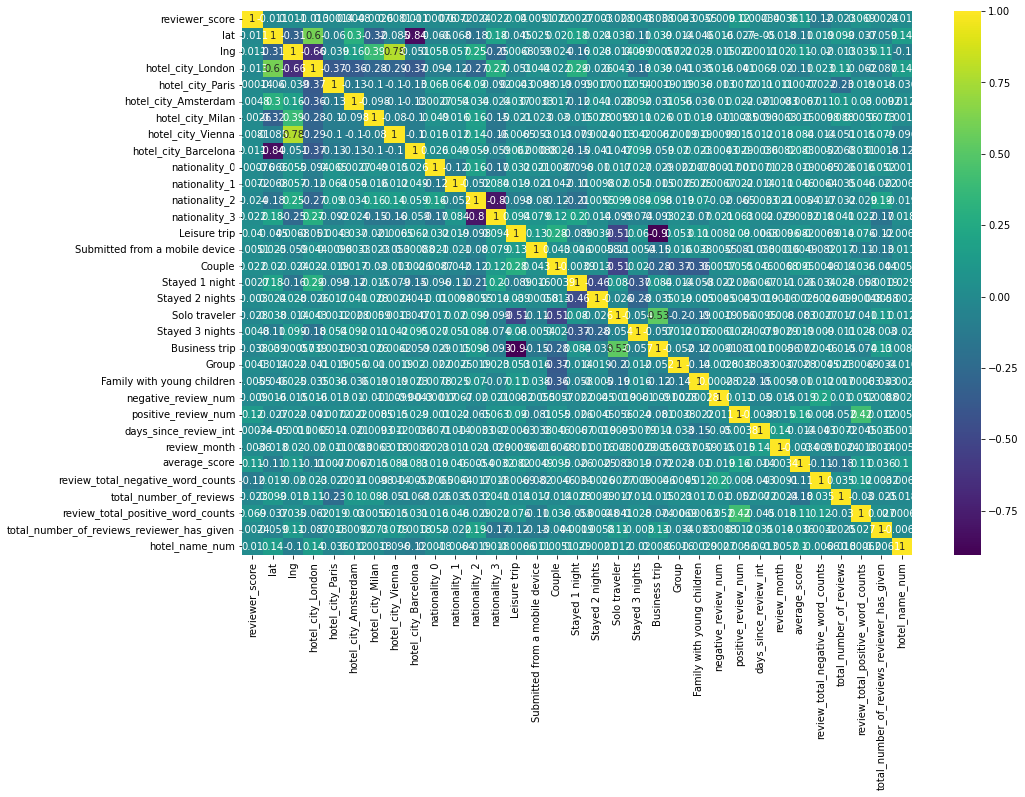

In [51]:
# Проверим корреляцию между признаками
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True, cmap='viridis');

## 3. ML
### Обучение модели

In [52]:
# выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [53]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [54]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 33), (386803, 33), (386803, 32), (309442, 32), (77361, 32))

In [56]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [57]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [58]:
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    9.2s finished


In [59]:
# Добавляем функцию Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее абсолютное процентное отклонение.
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 12.545707020066027


<AxesSubplot:>

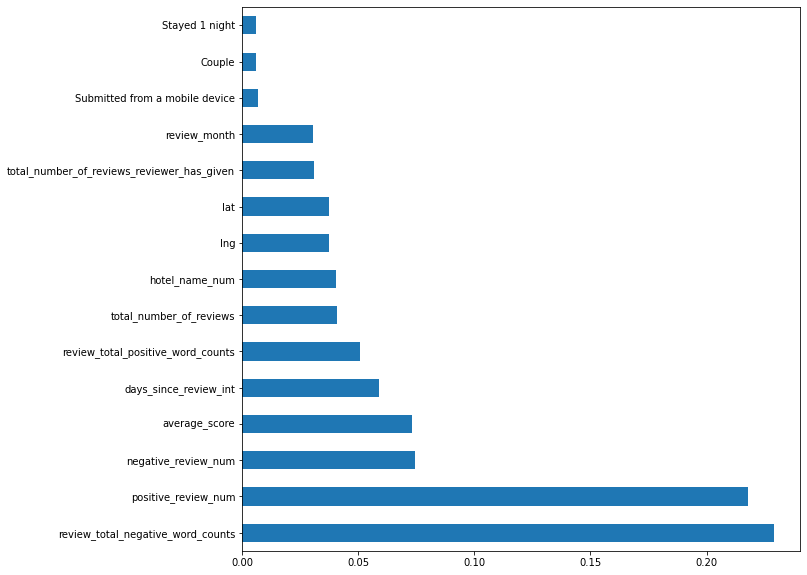

In [61]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [62]:
test_data.sample(10)

reviewer_score        lat        lng  hotel_city_London  \
512063             0.0  48.855532   2.362121                  0   
419976             0.0  48.214662  16.362799                  0   
493157             0.0  51.512022  -0.176241                  1   
414469             0.0  41.393597   2.174272                  0   
508674             0.0  51.514958  -0.082387                  1   
513543             0.0  51.513383  -0.192662                  1   
400516             0.0  51.514442  -0.146432                  1   
453822             0.0  51.491908  -0.168440                  1   
448128             0.0  51.510841  -0.078058                  1   
424950             0.0  48.218584  16.388134                  0   

        hotel_city_Paris  hotel_city_Amsterdam  hotel_city_Milan  \
512063                 1                     0                 0   
419976                 0                     0                 0   
493157                 0                     0                 0   
414469                 0                     0                 0   
508674                 0                     0                 0   
513543                 0                     0                 0   
400516                 0                     0                 0   
453822                 0                     0                 0   
448128                 0                     0                 0   
424950                 0                     0                 0   

        hotel_city_Vienna  hotel_city_Barcelona  nationality_0  ...  \
512063                  0                     0              0  ...   
419976                  1                     0              0  ...   
493157                  0                     0              0  ...   
414469                  0                     1              0  ...   
508674                  0                     0              0  ...   
513543                  0                     0              1  ...   
400516                  0                     0              0  ...   
453822                  0                     0              0  ...   
448128                  0                     0              0  ...   
424950                  1                     0              0  ...   

        negative_review_num  positive_review_num  days_since_review_int  \
512063              -0.7096               0.9889                    283   
419976              -0.2484               0.0000                     97   
493157              -0.7096               0.2500                     46   
414469               0.0000               0.0000                    267   
508674               0.7162               0.9607                    179   
513543              -0.7096               0.7346                    212   
400516              -0.2960               0.9249                    158   
453822               0.2263               0.8225                    472   
448128              -0.7096               0.9201                    474   
424950              -0.7096               0.9482                    590   

        review_month  average_score  review_total_negative_word_counts  \
512063            10       1.099381                          -0.624417   
419976             4       0.187051                           0.453358   
493157             6      -2.549937                          -0.624417   
414469             9       0.551983                          -0.287613   
508674             5      -1.820073                           3.013073   
513543             3      -1.455142                          -0.624417   
400516             2      -0.360346                          -0.186571   
453822             4      -0.360346                           0.049192   
448128             4       0.551983                          -0.624417   
424950            12       0.734449                          -0.624417   

        total_number_of_reviews  review_total_positive_word_counts  \
512063                -1.080

In [63]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [64]:
sample_submission

reviewer_score      id
0                    1  488440
1                   10  274649
2                    3  374688
3                   10  404352
4                    9  451596
...                ...     ...
128930               7  495812
128931               1  315577
128932               3  511968
128933               6  303386
128934               5  103157

[128935 rows x 2 columns]

In [65]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.2s finished


In [66]:
predict_submission

array([8.627, 6.901, 8.631, ..., 7.93 , 9.564, 7.202])

In [67]:
list(sample_submission)

['reviewer_score', 'id']

In [68]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('data/submission_v2.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.627  488440
1           6.901  274649
2           8.631  374688
3           9.733  404352
4           9.625  451596
5           8.969  302161
6           7.837  317079
7           7.418   13963
8           8.686  159785
9           7.586  195089